In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Cell 2: Load and preview dataset
# Make sure you have uploaded 'heart_failure_clinical_records_dataset.csv' into Colab
df = pd.read_csv("/content/heart.csv")

# Normalize column names
df.columns = [c.lower().replace(" ", "_") for c in df.columns]

# Quick look
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

# Check read_csv
print("Missing values:\n", df.isna().sum())

# Drop duplicates if any
df = df.drop_duplicates().reset_index(drop=True)

# Add categorical helpers
df['sex_label'] = df['sex'].map({0: 'female', 1: 'male'})
df['age_group'] = pd.cut(df['age'], bins=[0,50,70,np.inf], labels=["<50","50-70",">70"], right=False)

print("Preprocessing done!")


Shape: (918, 12)
Columns: ['age', 'sex', 'chestpaintype', 'restingbp', 'cholesterol', 'fastingbs', 'restingecg', 'maxhr', 'exerciseangina', 'oldpeak', 'st_slope', 'heartdisease']
Missing values:
 age               0
sex               0
chestpaintype     0
restingbp         0
cholesterol       0
fastingbs         0
restingecg        0
maxhr             0
exerciseangina    0
oldpeak           0
st_slope          0
heartdisease      0
dtype: int64
Preprocessing done!


In [8]:
# Cell 3: One-Sample T-Test for Cholesterol
# Continuous variable to test
var = 'cholesterol'
reference_value = 200  # normal clinical value

x = df[var].dropna()
n = len(x)
mean_val = x.mean()
std_val = x.std(ddof=1)

# One-sample t-test
t_stat, p_val = stats.ttest_1samp(x, popmean=reference_value)

print("=== One-Sample T-Test ===")
print(f"Variable tested      : {var}")
print(f"Sample size (n)      : {n}")
print(f"Sample mean          : {mean_val:.2f}")
print(f"Sample std. dev.     : {std_val:.2f}")
print(f"Reference mean       : {reference_value}")
print(f"T-statistic          : {t_stat:.3f}")
print(f"P-value              : {p_val:.4f}")

# Interpretation
alpha = 0.05
if p_val < alpha:
    print(f"Result: Sample mean of '{var}' differs significantly from {reference_value} (reject H0).")
else:
    print(f"Result: No significant difference (fail to reject H0).")


=== One-Sample T-Test ===
Variable tested      : cholesterol
Sample size (n)      : 918
Sample mean          : 198.80
Sample std. dev.     : 109.38
Reference mean       : 200
T-statistic          : -0.333
P-value              : 0.7396
Result: No significant difference (fail to reject H0).


In [9]:
# Cell 4: Two-Sample T-Test (maxhr by sex)


# Use lowercase column names (after cleaning)
group_col = 'sex'        # categorical variable: male/female
test_var = 'maxhr'       # continuous variable

# Prepare groups
g1 = df[df[group_col]==0][test_var].dropna()  # assuming 0=female
g2 = df[df[group_col]==1][test_var].dropna()  # assuming 1=male

# Check group sizes
print(f"Group sizes: {group_col}=0 -> {len(g1)}, {group_col}=1 -> {len(g2)}")

# Test for equal variances (Levene)
levene_stat, levene_p = stats.levene(g1, g2)
equal_var = levene_p > 0.05
print(f"Levene test for equal variances: stat={levene_stat:.3f}, p={levene_p:.4f} -> equal_var={equal_var}")

# Two-sample t-test
t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=equal_var)

# Results
print("\n=== Two-Sample T-Test ===")
print(f"Variable tested      : {test_var}")
print(f"Grouping variable    : {group_col} (0=female, 1=male)")
print(f"Mean group 0         : {g1.mean():.2f}")
print(f"Mean group 1         : {g2.mean():.2f}")
print(f"T-statistic          : {t_stat:.3f}")
print(f"P-value              : {p_val:.4f}")

# Interpretation
alpha = 0.05
if p_val < alpha:
    print(f"Result: Significant difference in '{test_var}' between groups (reject H0).")
else:
    print(f"Result: No significant difference between groups (fail to reject H0).")


Group sizes: sex=0 -> 0, sex=1 -> 0
Levene test for equal variances: stat=nan, p=nan -> equal_var=False

=== Two-Sample T-Test ===
Variable tested      : maxhr
Grouping variable    : sex (0=female, 1=male)
Mean group 0         : nan
Mean group 1         : nan
T-statistic          : nan
P-value              : nan
Result: No significant difference between groups (fail to reject H0).


In [12]:
# Cell 5: One-Way ANOVA (maxhr across chestpaintype)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Variables
dependent_var = 'maxhr'
factor_var = 'chestpaintype'

# Prepare model
model = ols(f'{dependent_var} ~ C({factor_var})', data=df).fit()

# Perform ANOVA
aov_table = sm.stats.anova_lm(model, typ=2)
print("=== ANOVA Results ===")
print(aov_table)

# Check significance
alpha = 0.05
if aov_table["PR(>F)"][0] < alpha:
    print(f"\nANOVA significant (p < {alpha}) -> Performing Tukey HSD post-hoc test\n")
    tukey = pairwise_tukeyhsd(endog=df[dependent_var], groups=df[factor_var], alpha=0.05)
    print(tukey.summary())
else:
    print(f"\nANOVA not significant (p >= {alpha}) -> No Tukey test needed")


=== ANOVA Results ===
                         sum_sq     df         F        PR(>F)
C(chestpaintype)   79522.267947    3.0  47.05307  2.786706e-28
Residual          514903.371487  914.0       NaN           NaN

ANOVA significant (p < 0.05) -> Performing Tukey HSD post-hoc test

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   ASY    ATA  21.7303    0.0  16.3363 27.1242   True
   ASY    NAP  14.7586    0.0   9.6687 19.8485   True
   ASY     TA  19.4135    0.0   9.9981 28.8289   True
   ATA    NAP  -6.9716 0.0239 -13.2926 -0.6507   True
   ATA     TA  -2.3168 0.9356 -12.4507  7.8172  False
   NAP     TA   4.6549 0.6264  -5.3206 14.6303  False
-----------------------------------------------------


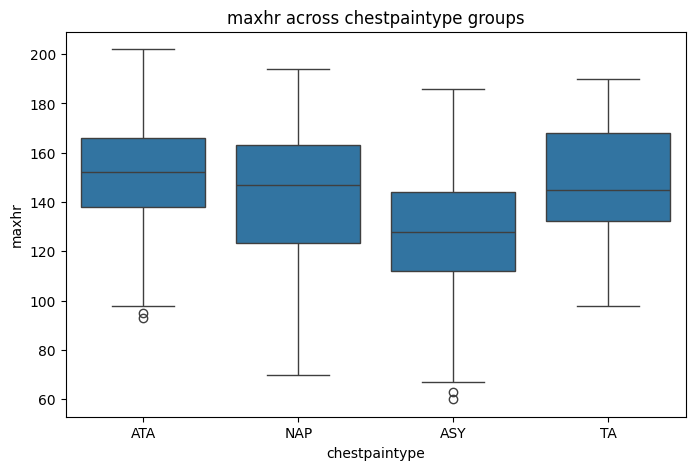

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x=factor_var, y=outcome_var, data=df)
plt.title(f'{outcome_var} across {factor_var} groups')
plt.xlabel(factor_var)
plt.ylabel(outcome_var)
plt.show()
